In [1]:
import os
import sys; sys.path.append('../')
import yaml
import pickle
import datetime
from contextlib import suppress


import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.calibration import CalibrationDisplay


import torch
import torchmetrics
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


import utils

In [2]:
with open('../configs/train.yaml', 'r') as stream:
    config = yaml.safe_load(stream)

In [3]:
v_size = config['split']['league']['val']
t_size = config['split']['league']['test']

In [4]:
train_df = pd.read_json(f'../parse/output/league/train_df.json')
print(len(train_df))

if v_size > 0:
    val_df = pd.read_json(f'../parse/output/league/val_df.json')
    print(len(val_df))
if t_size > 0:
    test_df = pd.read_json(f'../parse/output/league/test_df.json')
    print(len(test_df))

18098


In [5]:
train_df['part'] = 'train'
if v_size > 0: val_df['part'] = 'val'
if t_size > 0: test_df['part'] = 'test'

for eval_ in [True, ]:
    corpus = train_df.reset_index(drop=True)
    train_dataset = utils.nn.datasets.LeagueDataset(
        corpus=corpus, 
        evaluate_tokenize=eval_,
        indexes=corpus.index[(corpus['part'] == 'train')], 
        y_output='crossentropy',
    ).build()
    with open(f'output/train_cache{"_evaluated" if eval_ else ""}.pkl', 'wb') as p:
        pickle.dump(train_dataset.cache, p)

        
    if v_size > 0:
        corpus = pd.concat([corpus, val_df]).reset_index(drop=True)
        val_dataset = utils.nn.datasets.LeagueDataset(
            corpus=corpus, 
            evaluate_tokenize=eval_,
            indexes=corpus.index[(corpus['part'] == 'val')], 
            y_output='crossentropy',
        ).build()
        with open(f'output/val_cache{"_evaluated" if eval_ else ""}.pkl', 'wb') as p:
            pickle.dump(val_dataset.cache, p)
        
    if t_size > 0:
        corpus = pd.concat([corpus, test_df]).reset_index(drop=True)
        test_dataset = utils.nn.datasets.LeagueDataset(
            corpus=corpus, 
            evaluate_tokenize=eval_,
            indexes=corpus.index[(corpus['part'] == 'test')], 
            y_output='crossentropy',
        ).build()
        with open(f'output/test_cache{"_evaluated" if eval_ else ""}.pkl', 'wb') as p:
            pickle.dump(test_dataset.cache, p)

100%|████████████████████████████████████████████████████████████████████████████| 18098/18098 [03:53<00:00, 77.66it/s]


In [6]:
device = 'cuda'
batch_size = 1024

In [61]:
train_dataset = utils.nn.datasets.LeagueDataset(
    corpus=None, 
    indexes=None, 
    y_output='crossentropy')
train_dataset.cache = pickle.load(open('output/train_cache_evaluated.pkl', 'rb'))
train_dataset.build()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print(len(train_dataset))

if v_size > 0:
    val_dataset = utils.nn.datasets.LeagueDataset(
        corpus=None, 
        indexes=None, 
        y_output='crossentropy')
    val_dataset.cache = pickle.load(open('output/val_cache_evaluated.pkl', 'rb'))
    val_dataset.build()
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    print(len(val_dataset))
    
if t_size > 0:
    test_dataset = utils.nn.datasets.LeagueDataset(
        corpus=None, 
        indexes=None, 
        y_output='crossentropy')
    test_dataset.cache = pickle.load(open('output/test_cache_evaluated.pkl', 'rb'))
    test_dataset.build()
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    print(len(test_dataset))

12156


In [8]:
def get_writer(name:str):
    log_dir = f"logs/fit/prematch/{name}"
    writer = SummaryWriter(log_dir)
    return writer

def compute_metrics(y_pred, y_true):
    return {
        'Acc': float(torchmetrics.functional.accuracy(y_pred, y_true)),
        'AUC': float(torchmetrics.functional.auroc(y_pred, y_true)),
        'MAP': float(torchmetrics.functional.average_precision(y_pred, y_true)),
        'LogLoss': metrics.log_loss(y_true, y_pred),
    }

tokenizer = utils.tokenizer.Tokenizer(path="../parse/output/tokenizer_league.pkl")

utils.nn.PrematchModel(
    teams_num=max(tokenizer.teams_vocab.values()),
    regression=False,
).summary()

Layer (type:depth-idx)                                       Param #
├─Embedding: 1-1                                             848
├─WindowedGamesFeatureEncoder: 1-2                           --
|    └─StatsEncoder: 2-1                                     --
|    |    └─Linear: 3-1                                      800
|    |    └─Linear: 3-2                                      800
|    |    └─ModuleList: 3-3                                  960
|    └─ResultEncoder: 2-2                                    --
|    |    └─Embedding: 3-4                                   64
|    └─Embedding: 2-3                                        1,056
├─ModuleList: 1-3                                            --
|    └─TransformerEncoder: 2-4                               --
|    |    └─LayerNorm: 3-5                                   64
|    |    └─LayerNorm: 3-6                                   64
|    |    └─MultiheadAttention: 3-7                          4,224
|    |    └─PositionWiseF

In [9]:
preds = []
results = []
models_names = []

date = datetime.datetime.now().strftime("%Y.%m.%d - %H-%M")
for n in range(4):    
    torch.cuda.empty_cache()
    
    name = f'Ensemble {n} {date}'
    writer = get_writer(name)

    model = utils.nn.PrematchModel(
        teams_num=max(tokenizer.teams_vocab.values()),
        regression=False,
    )

    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.2)
    scheduler = utils.nn.shedulers.TransformerLRScheduler(
        optimizer=optimizer,
        init_lr=1e-5,
        peak_lr=1e-3,
        final_lr=1e-5,
        final_lr_scale=0.01,
        warmup_steps=10,
        decay_steps=70,
    )

    trainer = utils.nn.trainers.PremtachTrainer(
        model=model, 
        loss_fn=torch.nn.CrossEntropyLoss(), 
        sheduler=scheduler,
        optimizer=optimizer,
        metric={
            "Acc": torchmetrics.Accuracy(num_classes=2),
            "AUC": torchmetrics.AUROC(num_classes=2),
            "MAP": torchmetrics.AveragePrecision(num_classes=2),
        },
        device=device
    )

    # --------------------------------------------------------- #
    wait = 0
    patience = 50

    epoch = 0
    best_loss = -np.inf

    with suppress(KeyboardInterrupt):
        while epoch < 80:
            # --------------------------------------------- #
            # Train
            train_loss = trainer.train_epoch(train_loader)
            writer.add_scalar('LogLoss/train', train_loss, epoch)
            writer.add_scalar('Acc/train', trainer.metric['Acc'].compute(), epoch)
            writer.add_scalar('AUC/train', trainer.metric['AUC'].compute(), epoch)
            writer.add_scalar('MAP/train', trainer.metric['MAP'].compute(), epoch)
            
            # --------------------------------------------- #
            # Val
            if v_size > 0:
                val_pred, val_true = trainer.predict(val_loader)
                val_pred = val_pred.softmax(dim=1)[:, 1]
                val_metrics = compute_metrics(val_pred, val_true)
                for _metric in val_metrics:
                    writer.add_scalar(f'{_metric}/val', val_metrics[_metric], epoch)
                
            # --------------------------------------------- #
            # Test    
            if t_size > 0:
                test_pred, test_true = trainer.predict(test_loader)
                test_pred = test_pred.softmax(dim=1)[:, 1]
                test_metrics = compute_metrics(test_pred, test_true)
                for _metric in test_metrics:
                    writer.add_scalar(f'{_metric}/test', test_metrics[_metric], epoch)
                
            # --------------------------------------------- #
            # EarlyStopping
            wait, epoch = wait+1, epoch+1
            # if val_metrics['AUC'] > best_loss:
                # torch.save(trainer.checkpoint(), f'output/models_w/prematch/{name}.torch')
                # best_loss = val_metrics['AUC']
                # wait = 0
        checkpoint = trainer.checkpoint()
        checkpoint['kwargs'] = {
            'teams_num': max(tokenizer.teams_vocab.values()), 
            'regression': False,
        }
        torch.save(checkpoint, f'output/models_w/prematch/{name}.torch')

    # --------------------------------------------- #
    # Load and evaluate
    if t_size > 0 or v_size > 0:
    
        checkpoint = torch.load(f'output/models_w/prematch/{name}.torch')
        trainer.model.load_state_dict(checkpoint['model'])

        test_pred, test_true = trainer.predict(test_loader if t_size > 0 else val_loader)
        test_pred = test_pred.softmax(dim=1)[:, 1]

        test_metrics = compute_metrics(test_pred, test_true)
        test_metrics['epoch'] = epoch

        preds.append(test_pred)
        results.append(test_metrics)
        models_names.append(name)
    
if t_size > 0 or v_size > 0:
    preds = torch.vstack(preds)

C:\Users\royta\AppData\Local\Programs\Python\Python310\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
C:\Users\royta\AppData\Local\Programs\Python\Python310\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [62]:
preds = []
results = []
for name in models_names:
    checkpoint = torch.load(f'output/models_w/prematch/{name}.torch')
    trainer.model.load_state_dict(checkpoint['model'])
        
    pred, true = trainer.predict(train_loader)
    pred = pred.softmax(dim=1)[:, 1]

    _metrics = compute_metrics(pred, true)
    _metrics['epoch'] = epoch

    preds.append(pred)
    results.append(_metrics)
    
preds = torch.vstack(preds)
ensemble_mean_pred = preds.mean(dim=0)

In [64]:
compute_metrics(ensemble_mean_pred[-200:], true[-200:])

{'Acc': 0.5450000166893005,
 'AUC': 0.5874384641647339,
 'MAP': 0.5772390961647034,
 'LogLoss': 0.6693966773152351}

In [11]:
batch_size = 128
stride = 32

to_plot = {
    'Acc': [],
    'AUC': [],
    'MAP': [],
    'LogLoss': [],
}
for batch in range(0, len(true)-batch_size, stride):
    _m = compute_metrics(ensemble_mean_pred[batch:batch+batch_size], true[batch:batch+batch_size])
    
    for key in _m: to_plot[key].append(_m[key])
    
del to_plot['LogLoss']

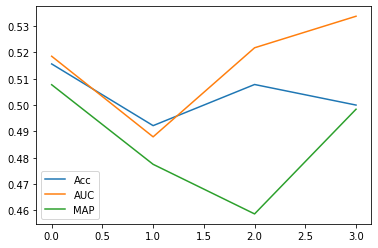

In [12]:
for k in to_plot:
    plt.plot(to_plot[k])

plt.legend(to_plot.keys())

C:\Users\royta\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\royta\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

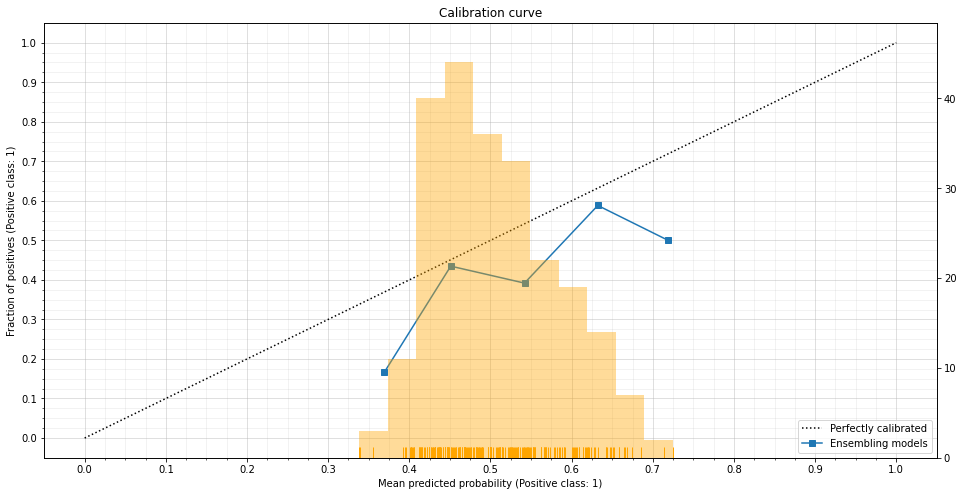

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.set_title("Calibration curve")
display = CalibrationDisplay.from_predictions(
    true,
    ensemble_mean_pred, 
    n_bins=10,
    name="Ensembling models",
    ax=ax,
)


major_ticks = np.arange(0, 1+1e-6, 0.1)
minor_ticks = np.arange(0, 1+1e-6, 0.025)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)


_ax = ax.twinx()
sns.distplot(ensemble_mean_pred, ax=_ax, color='orange', hist=True, kde=False, rug=True)

#

In [ ]:
odds = pd.read_csv("../odds.csv")

M = (1/odds['radiant_odd'] + 1/odds['dire_odd']) - 1

odds['r_pred'] = (1-M)/odds['radiant_odd']
odds['d_pred'] = (1-M)/odds['dire_odd']

odds = odds[odds['match_id'] > 6000000000]

compute_metrics(
    y_pred=torch.from_numpy(1/odds['radiant_odd'].values), 
    y_true=torch.from_numpy(odds['radiant_win'].values.astype('int64'))
)

In [ ]:
odds = pd.concat([pd.read_json("../scarpe/output/odds1.json"), pd.read_json("../scarpe/output/odds2.json")])
odds = pd.read_json("../scarpe/output/odds1.json")
odds = odds.drop_duplicates('match_id').reset_index()

true = []
my_pred = []
book_pred = []

_, test_true = trainer.predict(test_loader)
for idx, batch in enumerate(DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)):
    # if idx == 200: break
    match_id = batch['match_id'].item()

    if (odds['match_id'] == match_id).any():
        true.append( test_true[idx].item() )
        my_pred.append( ensemble_mean_pred[idx].item() )
        book_pred.append( 1/odds[odds['match_id'] == match_id]['r_odd'].values[0] )
        
true = torch.IntTensor(true)
my_pred = torch.Tensor(my_pred)
book_pred = torch.Tensor(book_pred)

print("My metrics")
print(compute_metrics(my_pred, true))

print("Book metrics")
print(compute_metrics(book_pred, true))

In [98]:
team1 = tokenizer.teams_vocab[7119388]
team2 = tokenizer.teams_vocab[15]
for batch in train_loader:
    b = ((batch['teams']['dire'] == team1) & (batch['teams']['radiant'] == team2)) | ((batch['teams']['dire'] == team2) & (batch['teams']['radiant'] == team1))
    if b.any():
        print('Founded')
        break

Founded


In [103]:
output = model(trainer.batch_to_device(batch, 'cuda'))

In [106]:
batch['teams']['dire'][b]

tensor([4, 4], device='cuda:0')

In [107]:
batch['teams']['radiant'][b]

tensor([20, 20], device='cuda:0')

In [105]:
output[b].softmax(dim=1)

tensor([[0.4734, 0.5266],
        [0.5913, 0.4087]], device='cuda:0', grad_fn=<SoftmaxBackward0>)